# Team E Assignment #2

by Dominic Dill, Saideep Reddy Arikonthman, Guoyi Zhang, Keke Zhang


In [79]:
import pandas as pd

import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

import contractions

import numpy as np
 
import matplotlib.pyplot as plt

import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.model_selection import GridSearchCV

import xgboost as xgb

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping


## Set code hyperparameters

In [8]:
#testing flag for subsetting data
testing = True
frac = 0.01 # fraction of data to use for testing
# save_data = False # to save the reduced TF-IDF data to a file so we don't need to recalculate it
# load_data = False
# saved_data = 'tfidf_data.csv'

target = 'category'

t_size = 0.2 # test size (% of data to send to test set)
v_size = 0.2 # validation size (% of train data to send to validation set)

# preprocessing parameters
lemmatize = False # lemmatize or stem words, false means stem

#TF-IDF parameters
tfidf_col = 'processed_headline' #options: 'processed_headline', 'processed_short_description', 'processed_text' <-- combo of both headline and short_description post processing
max_features = 5000
max_df = 1.0
min_df = 1
stop_words = 'english'
ngram_range = (1,2)

#LSA Dimension Reduction Parameters
n_components = 5000
retained_variance = 0.85

#set columns to drop for machine learning training
non_ml_attr = ['Unnamed: 0', 'headline', 'short_description', 'date', 'authors', 'processed_headline', 'processed_short_description', 'processed_text']

#set figure sizes, make them a little larger than default
plt.rcParams['figure.figsize'] = [12, 12]


## Useful functions

In [9]:
def get_missingness(dframe):
    missing_columns = []
    for column in dframe.columns:
        na_perc=np.sum(dframe[column].isna())/dframe.shape[0]
        print(f"{column:<30}{round(na_perc*100,1)}%")
        if na_perc>0.2:
            print(f"\n{column} missingness too high ({round(na_perc,3)*100}%)\n")
            missing_columns.append(column)
    return missing_columns

def preprocess_text(text):
    # Convert to lower case
    text = text.lower()
    
    ## add space inbetween numbers and letters (e.g. 5mg to 5 mg, 17yo to 17 yo)
    # text = re.sub(r'(\d+)([a-zA-Z])', r'\1 \2', text)
    
    #remove numbers
    text = re.sub(r'\d+', '', text)

    # Expand contractions (e.g., "can't" to "can not")
    text = contractions.fix(text)
    
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', ' ', text)

    # Apply stopwords list
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    # Lemmatize the words
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    else:
        stemmer = PorterStemmer()
        text = ' '.join([stemmer.stem(word) for word in text.split()])

    return text

#all of these default values are set in the cell above, code hyperparameters 
def get_tfidf(train_col, test_col, val_col, ngram_range=ngram_range, max_features=max_features, max_df=max_df, min_df=min_df, stop_words=stop_words):
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features, max_df=max_df, min_df=min_df, stop_words=stop_words)
    train_tfidf = vectorizer.fit_transform(train_col)
    test_tfidf = vectorizer.transform(test_col)
    val_tfidf = vectorizer.transform(val_col)

    print(f"Train document count: {train_col.shape[0]}")
    print(f"Train feature count: {train_tfidf.shape[1]}")
    print(f"Test document count: {test_col.shape[0]}")
    print(f"Test feature count: {test_tfidf.shape[1]}")
    print(f"Val document count: {val_col.shape[0]}")
    print(f"Val feature count: {val_tfidf.shape[1]}")
    
    return train_tfidf, test_tfidf, val_tfidf, vectorizer

def lsa_dimension_reduction(train_tfidf, test_tfidf, val_tfidf, n_components=n_components, retained_variance=retained_variance):
    lsa = make_pipeline(TruncatedSVD(n_components=n_components), Normalizer(copy=False)) #set number of components to half the number of features because the number of features is very large and I don't think we need them all, this might speed up the code
    train_lsa = lsa.fit_transform(train_tfidf)
    test_lsa = lsa.transform(test_tfidf)
    val_lsa = lsa.transform(val_tfidf)
    cumsum = np.cumsum(lsa[0].explained_variance_ratio_) #create vector where each element is the sum of the explained variance up to that point
    
    if cumsum[-1] < retained_variance: #if the explained variance is less than the threshold, print a warning
        print(f"Warning: The explained variance is only {cumsum[-1]} which is less than the threshold of {retained_variance}")
    else:
        ind = np.argmax(cumsum > retained_variance) + 1 #find the index of the first element that has a sum of explained variance greater than the threshold
        train_lsa = train_lsa[:, :ind] #keep only the first ind columns
        test_lsa = test_lsa[:, :ind]
        val_lsa = val_lsa[:, :ind]
        print(f"Explained variance: {round(cumsum[ind-1],3)}")
    
    print(f"Train shape before reduction: {train_tfidf.shape}")
    print(f"Train shape after reduction: {train_lsa.shape}")
    print(f"{round((1-train_lsa.shape[1]/train_tfidf.shape[1])*100,3)}% reduction in features")
    print(f"\nTest shape before reduction: {test_tfidf.shape}")
    print(f"Test shape after reduction: {test_lsa.shape}")
    print(f"{round((1-test_lsa.shape[1]/test_tfidf.shape[1])*100,3)}% reduction in features")
    print(f"\nVal shape before reduction: {val_tfidf.shape}")
    print(f"Val shape after reduction: {val_lsa.shape}")
    print(f"{round((1-val_lsa.shape[1]/val_tfidf.shape[1])*100,3)}% reduction in features")
    
    return train_lsa, test_lsa, val_lsa


def get_x_y(dframe,target):
    x = dframe.loc[:, dframe.columns != target]
    y = dframe[target].values.ravel()

    return x,y



## Load data, subsample if testing is true for faster development

In [10]:
df = pd.read_csv('News_Category_Dataset_v3.csv', dtype=str)

print(df.shape)

if testing:
    df = resample(df, n_samples=round(frac*df.shape[0]), replace = False, random_state=42, stratify=df[target])

df.shape

(209527, 8)


(2095, 8)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2095 entries, 183552 to 164186
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Unnamed: 0                2095 non-null   object
 1   headline                  2095 non-null   object
 2   category                  2095 non-null   object
 3   short_description         1917 non-null   object
 4   authors                   1708 non-null   object
 5   date                      2095 non-null   object
 6   headline_length           2095 non-null   object
 7   short_description_length  2095 non-null   object
dtypes: object(8)
memory usage: 147.3+ KB


In [12]:
get_missingness(df)

Unnamed: 0                    0.0%
headline                      0.0%
category                      0.0%
short_description             8.5%
authors                       18.5%
date                          0.0%
headline_length               0.0%
short_description_length      0.0%


[]

## Drop rows with missing headline and/or missing short description and/or missing category

In [13]:
df = df[df['headline'].notna()]
df = df[df['short_description'].notna()]
df = df[df['category'].notna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1917 entries, 183552 to 164186
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Unnamed: 0                1917 non-null   object
 1   headline                  1917 non-null   object
 2   category                  1917 non-null   object
 3   short_description         1917 non-null   object
 4   authors                   1566 non-null   object
 5   date                      1917 non-null   object
 6   headline_length           1917 non-null   object
 7   short_description_length  1917 non-null   object
dtypes: object(8)
memory usage: 134.8+ KB


### Convert date str to datetime object

In [14]:
df['date'] = pd.to_datetime(df['date'])
df['headline_length'] = pd.to_numeric(df['headline_length'])
df['short_description_length'] = pd.to_numeric(df['short_description_length'])

## Label Encode Categories

In [15]:
label_encoder = LabelEncoder()
df['category'] = label_encoder.fit_transform(df[target])

label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

pd.DataFrame.from_dict(label_map, orient='index').to_csv('label_encoding_map.csv', header=False)

## Preprocess headline and short description

In [16]:
df['processed_headline'] = df['headline'].apply(preprocess_text)
df['processed_short_description'] = df['short_description'].apply(preprocess_text)
df['processed_text'] = df['processed_headline'] + ' ' + df['processed_short_description']
df.head(5)

,Unnamed: 0,headline,category,short_description,authors,date,headline_length,short_description_length,processed_headline,processed_short_description,processed_text
183552,183552,Mark Hamill & 'Star Wars': Luke Skywalker Acto...,10,"""It's the last one for everyone except for the...",NaN,2012-11-03,60,122,mark hamil star war luke skywalk actor episod,last one everyon except two robot one go whole...,mark hamil star war luke skywalk actor episod ...
53746,53746,Survivors Of Rape And Forced Marriage Seek Jus...,33,"In Cambodia, the U.N.-backed Khmer Rouge tribu...","Nina Teggarty, Women & Girls Hub",2016-10-17,83,123,survivor rape forc marriag seek justic cambodi...,cambodia n back khmer roug tribun hear survivo...,survivor rape forc marriag seek justic cambodi...
32405,32405,Religious Freedom And LGBTQ Rights Move From B...,25,Lakshman Kalasapudi is a volunteer for SALGA-N...,"Ilgin Yorulmaz, ContributorFreelance Turkish J...",2017-06-17,74,122,religi freedom lgbtq right move battleground c...,lakshman kalasapudi volunt salga nyc non profi...,religi freedom lgbtq right move battleground c...
188472,188472,"Neon Hitch, Singer/Songwriter, Has The Same He...",30,Watch the video above to find out why she thin...,Michelle Persad,2012-09-11,70,123,neon hitch singer songwrit headdress jay z video,watch video find think queen anoth life want s...,neon hitch singer songwrit headdress jay z vid...
209096,209096,"Astrology Now: Relationships, Projects Coming ...",38,This can be a high-urgency week wherein many m...,"Phyllis F. Mitz, Contributor\nAstrology, Spiri...",2012-02-01,55,202,astrolog relationship project come head,high urgenc week wherein mani matter come head...,astrolog relationship project come head high u...


In [17]:
df.shape

(1917, 11)

## Test Train Split

In [18]:
train_df, test_df = train_test_split(df, test_size=t_size, random_state=42, stratify=df[target])
train_df, val_df = train_test_split(train_df, test_size=v_size, random_state=42, stratify=train_df[target])

print(f"Train: {train_df.shape[0]} samples\nTest: {test_df.shape[0]} samples\nValidation: {val_df.shape[0]} samples")

Train: 1226 samples
Test: 384 samples
Validation: 307 samples


## Create TF-IDF for the tfidf_col (set in second cell, hyperparameters settings) for all datasets (train, test, val)
Fit-transform TfidfVectorizer to train dataset, transform (but not fit) the test and val datasets

In [19]:
train_tfidf, test_tfidf, val_tfidf, headline_vectorizer = get_tfidf(train_df[tfidf_col], test_df[tfidf_col], val_df[tfidf_col])

Train document count: 1226
Train feature count: 5000
Test document count: 384
Test feature count: 5000
Val document count: 307
Val feature count: 5000


## Save the TF-IDF features names to a CSV, easy way to look at them to assess our preprocessing

In [41]:
#pd.DataFrame(train_tfidf.todense(), columns=headline_vectorizer.get_feature_names_out()).to_csv('train_tfidf.csv', index=True)
pd.Series(headline_vectorizer.get_feature_names_out()).to_csv('tfidf_feature_names.csv', index=False)


## Reduce Dimensions of the headline tfidf's using LSA
again, fit-transform to train dataset, then transform the test and val set

In [21]:
train_lsa, test_lsa, val_lsa = lsa_dimension_reduction(train_tfidf, test_tfidf, val_tfidf)
del train_tfidf, test_tfidf, val_tfidf

Explained variance: 0.85
Train shape before reduction: (1226, 5000)
Train shape after reduction: (1226, 821)
83.58% reduction in features

Test shape before reduction: (384, 5000)
Test shape after reduction: (384, 821)
83.58% reduction in features

Val shape before reduction: (307, 5000)
Val shape after reduction: (307, 821)
83.58% reduction in features


## Visualize matrices before and after dimension reduction. Is there any reason to do this?

In [22]:
# lsa_projections = {'headline_dtm': [headline_train_tfidf, headline_train_lsa], 'short_description_dtm': [short_description_dtm,short_description_reduced_dtm], 'text_dtm': [text_dtm, text_reduced_dtm]}

In [23]:
# for key, value in lsa_projections.items():
#     print(f"{key} pre-LSA")
#     plt.imshow(pd.DataFrame(value[0].todense()), norm='log')
#     plt.show()
#     print(f"{key} post-LSA")
#     plt.imshow(pd.DataFrame(value[1]), norm='log')
#     plt.show()


## Merge the LSA dimension reduced TF-IDF data back with the other features (like author, date, headline length, target, etc.)
concatenate the LSA outputs from above onto the train, test, and val dataframes

In [24]:
# train
lsa_df = pd.DataFrame(train_lsa, index=train_df.index).add_prefix('lsa_') #take the TF-IDF post-lsa and convert it to a dataframe
train = pd.concat([train_df, lsa_df], axis=1)
assert train.shape[0] == train_df.shape[0]
assert train.shape[1] == train_df.shape[1] + lsa_df.shape[1]
del lsa_df

#test
lsa_df = pd.DataFrame(test_lsa, index=test_df.index).add_prefix('lsa_') #take the test TF-IDF post-lsa and convert it to a dataframe
test = pd.concat([test_df, lsa_df], axis=1)
assert test.shape[0] == test_df.shape[0]
assert test.shape[1] == test_df.shape[1] + lsa_df.shape[1]
del lsa_df

#validation
lsa_df = pd.DataFrame(val_lsa, index=val_df.index).add_prefix('lsa_') #take the validation TF-IDF post-lsa and convert it to a dataframe
val = pd.concat([val_df, lsa_df], axis=1)
assert val.shape[0] == val_df.shape[0]
assert val.shape[1] == val_df.shape[1] + lsa_df.shape[1]
del lsa_df

## Drop the non ml attributes, as defined in the hyperparameters section

In [25]:
train = train.drop(columns=non_ml_attr)
test = test.drop(columns=non_ml_attr)
val = val.drop(columns=non_ml_attr)

## Get train and test x and y

In [26]:
train_x, train_y = get_x_y(train, target)
train_x.head(5)

,headline_length,short_description_length,lsa_0,lsa_1,lsa_2,lsa_3,lsa_4,lsa_5,lsa_6,lsa_7,...,lsa_811,lsa_812,lsa_813,lsa_814,lsa_815,lsa_816,lsa_817,lsa_818,lsa_819,lsa_820
165067,63,124,0.053841,0.216093,-0.094300,-0.083730,-0.005694,-0.016851,-0.019921,-0.001462,...,-0.007055,-0.016360,-0.019958,-0.007116,0.009349,0.021532,-0.007933,0.006128,-0.018259,-0.011622
112743,32,269,0.024633,0.037505,0.058530,0.030052,0.005680,-0.007506,0.016058,0.023123,...,0.009880,-0.000573,0.009540,0.021734,0.017252,-0.012504,0.018507,0.000600,-0.021022,0.007962
33639,61,45,0.039473,0.059676,0.025545,0.143422,-0.101257,0.019271,-0.099319,-0.058003,...,0.016237,-0.045478,0.012848,-0.006523,0.005314,0.015721,-0.032305,-0.011548,-0.010824,0.025124
82587,42,103,0.022974,0.013295,-0.000198,0.015821,0.023002,0.010066,0.011868,0.053871,...,0.023670,0.017958,-0.007760,-0.011119,0.030235,-0.005739,-0.013275,-0.001484,-0.009804,-0.025397
170647,58,167,0.007387,0.016045,-0.004297,0.009029,-0.005401,-0.001071,-0.003041,-0.001916,...,0.002155,0.001531,-0.017586,0.018939,0.013571,0.002529,-0.005740,-0.001771,-0.002248,0.002549


In [27]:
test_x, test_y = get_x_y(test, target)

# Start Softmax (multiclass logistic) regression modeling

In [28]:
clf = make_pipeline(StandardScaler(), LogisticRegression(multi_class='multinomial', solver = 'lbfgs', C = 100.0, max_iter = 1000))
clf.fit(train_x, train_y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=100.0, max_iter=1000,
                                    multi_class='multinomial'))])

In [29]:
train_predictions = clf.predict(train_x)
test_predictions = clf.predict(test_x)

## Get metrics

In [30]:
print(f"Train accuracy: {clf.score(train_x, train_y):.3f}")
print(f"Train precision: {precision_score(train_y, train_predictions, average='weighted'):.3f}")
print(f"Train recall: {recall_score(train_y, train_predictions, average='weighted'):.3f}")
print(f"Train f1: {f1_score(train_y, train_predictions, average='weighted'):.3f}")
print("\n")
print(f"Test accuracy: {clf.score(test_x, test_y):.3f}")
print(f"Test precision: {precision_score(test_y, test_predictions, average='weighted'):.3f}")
print(f"Test recall: {recall_score(test_y, test_predictions, average='weighted'):.3f}")
print(f"Test f1: {f1_score(test_y, test_predictions, average='weighted'):.3f}")


Train accuracy: 0.998
Train precision: 0.998
Train recall: 0.998
Train f1: 0.998


Test accuracy: 0.336
Test precision: 0.327
Test recall: 0.336
Test f1: 0.325


c:\Users\domin\anaconda3\envs\nlp_env\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Plot the confusion matrix

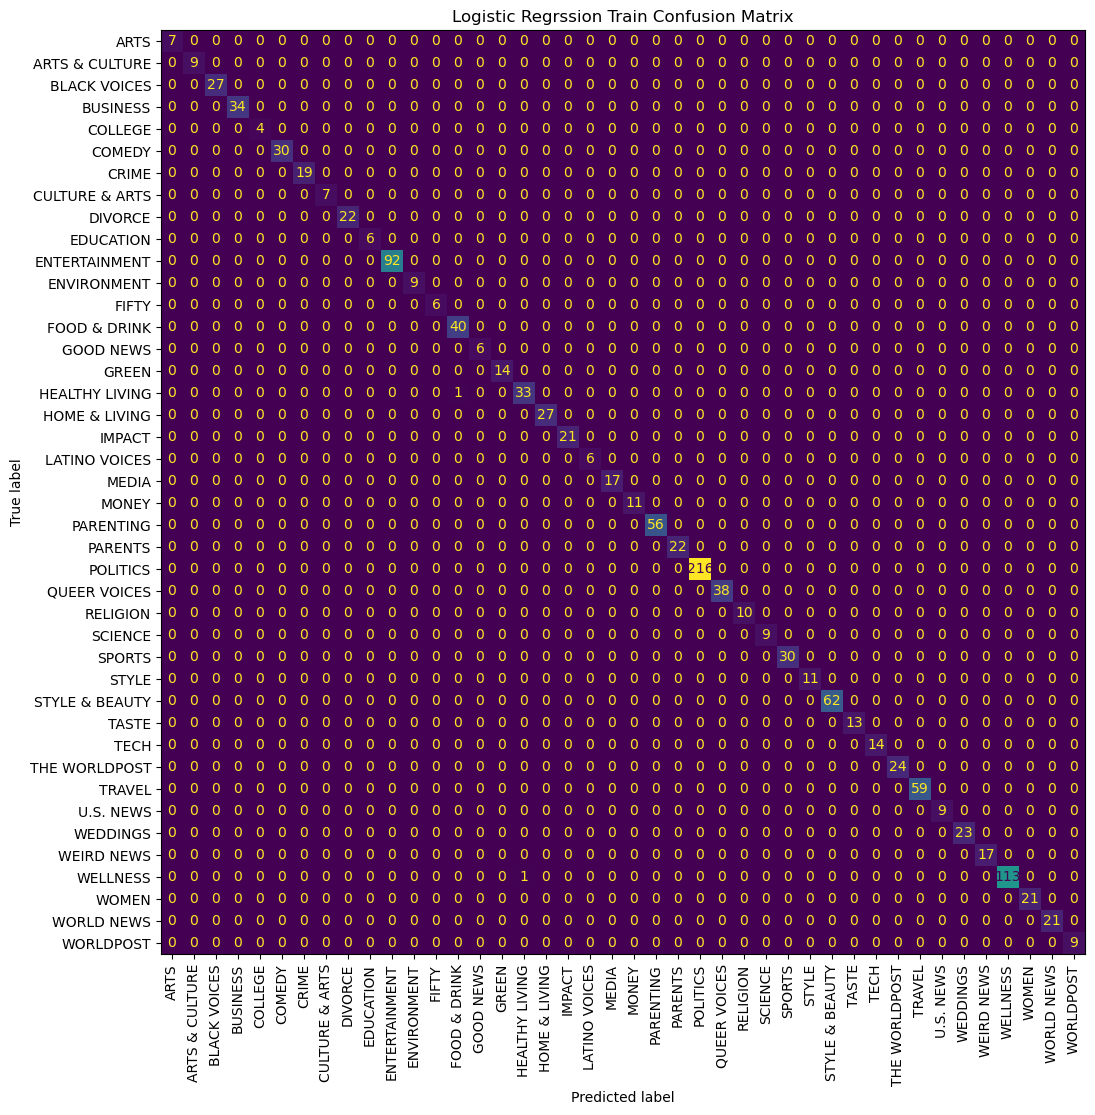

In [31]:
ConfusionMatrixDisplay.from_predictions(train_y, train_predictions, display_labels=label_encoder.classes_, colorbar=False, xticks_rotation='vertical')
plt.title('Logistic Regrssion Train Confusion Matrix')
plt.show()

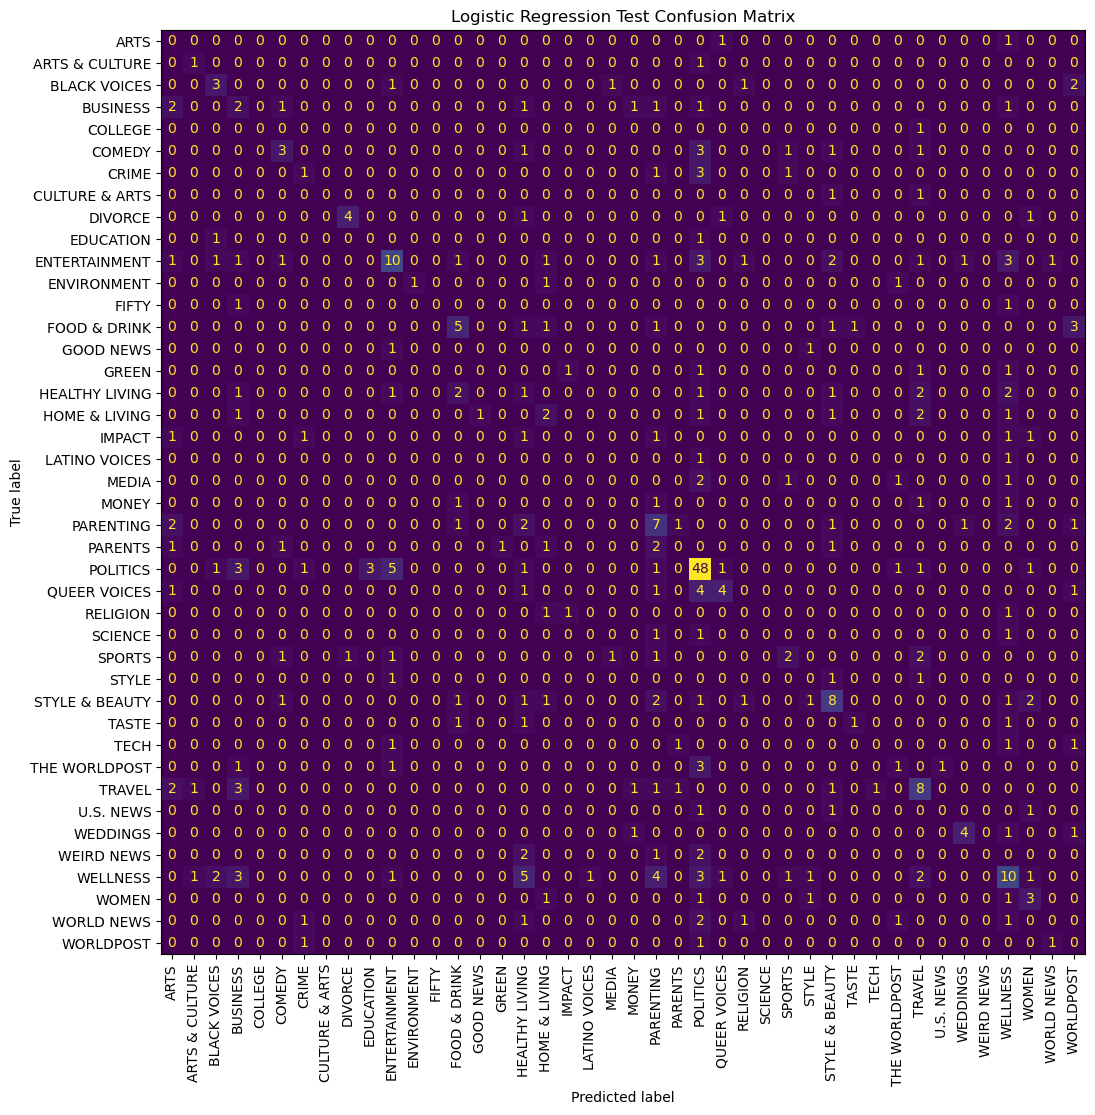

In [32]:
#test confusion matrix
ConfusionMatrixDisplay.from_predictions(test_y, test_predictions, display_labels=label_encoder.classes_, colorbar=False, xticks_rotation='vertical')
plt.title('Logistic Regression Test Confusion Matrix')
plt.show()

## Random Forest Classifier

In [33]:
clf = RandomForestClassifier(n_estimators=1000, max_depth=5, random_state=42, class_weight='balanced')
clf.fit(train_x, train_y)

train_predictions = clf.predict(train_x)
test_predictions = clf.predict(test_x)

In [34]:
print(f"Train accuracy: {clf.score(train_x, train_y):.3f}")
print(f"Train precision: {precision_score(train_y, train_predictions, average='weighted'):.3f}")
print(f"Train recall: {recall_score(train_y, train_predictions, average='weighted'):.3f}")
print(f"Train f1: {f1_score(train_y, train_predictions, average='weighted'):.3f}")
print("\n")
print(f"Test accuracy: {clf.score(test_x, test_y):.3f}")
print(f"Test precision: {precision_score(test_y, test_predictions, average='weighted'):.3f}")
print(f"Test recall: {recall_score(test_y, test_predictions, average='weighted'):.3f}")
print(f"Test f1: {f1_score(test_y, test_predictions, average='weighted'):.3f}")

Train accuracy: 0.927
Train precision: 0.941
Train recall: 0.927
Train f1: 0.931


Test accuracy: 0.185
Test precision: 0.207
Test recall: 0.185
Test f1: 0.186


c:\Users\domin\anaconda3\envs\nlp_env\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


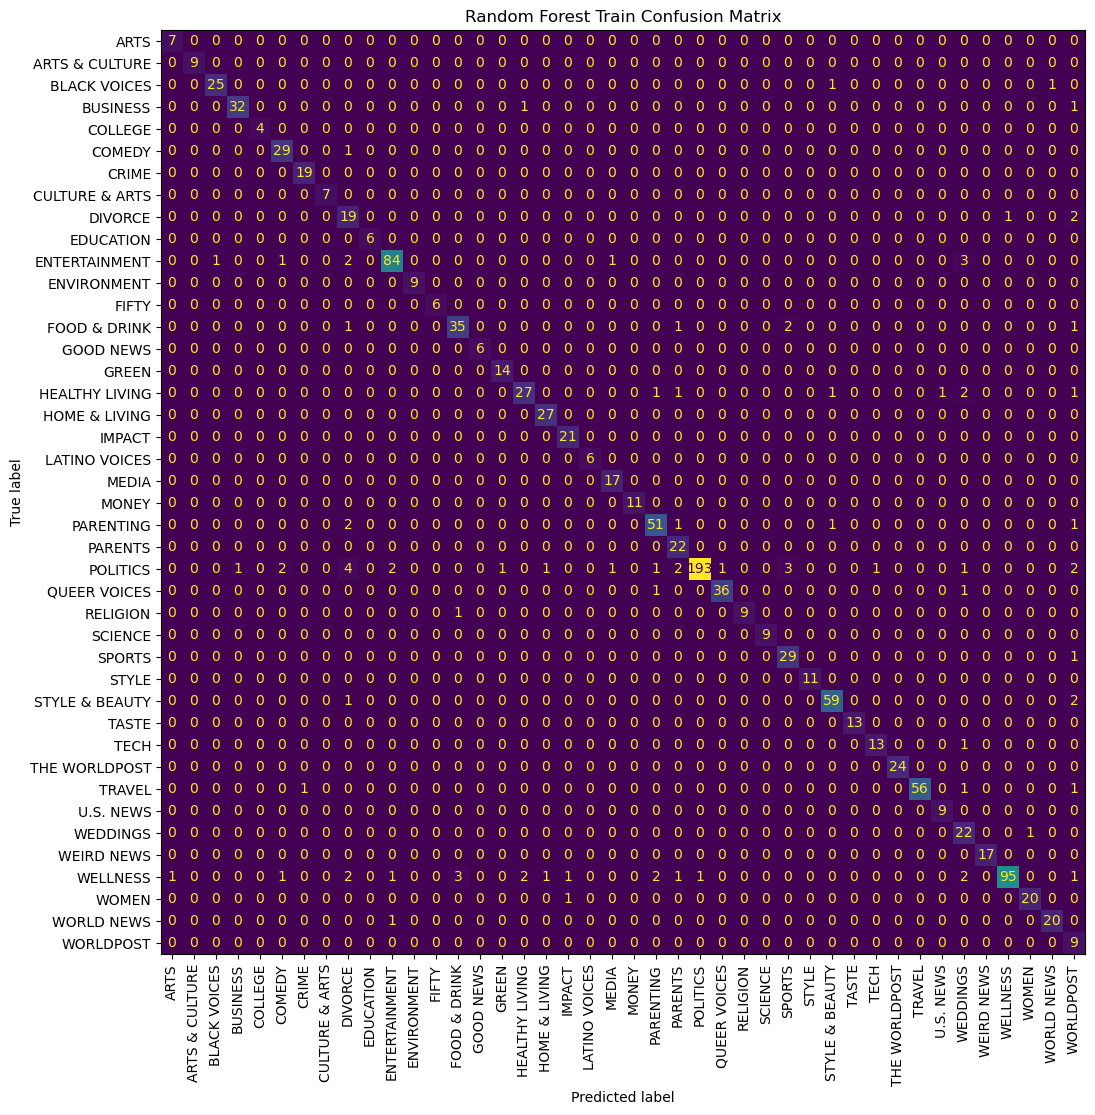

In [35]:
ConfusionMatrixDisplay.from_predictions(train_y, train_predictions, display_labels=label_encoder.classes_, colorbar=False, xticks_rotation='vertical')
plt.title('Random Forest Train Confusion Matrix')
plt.show()

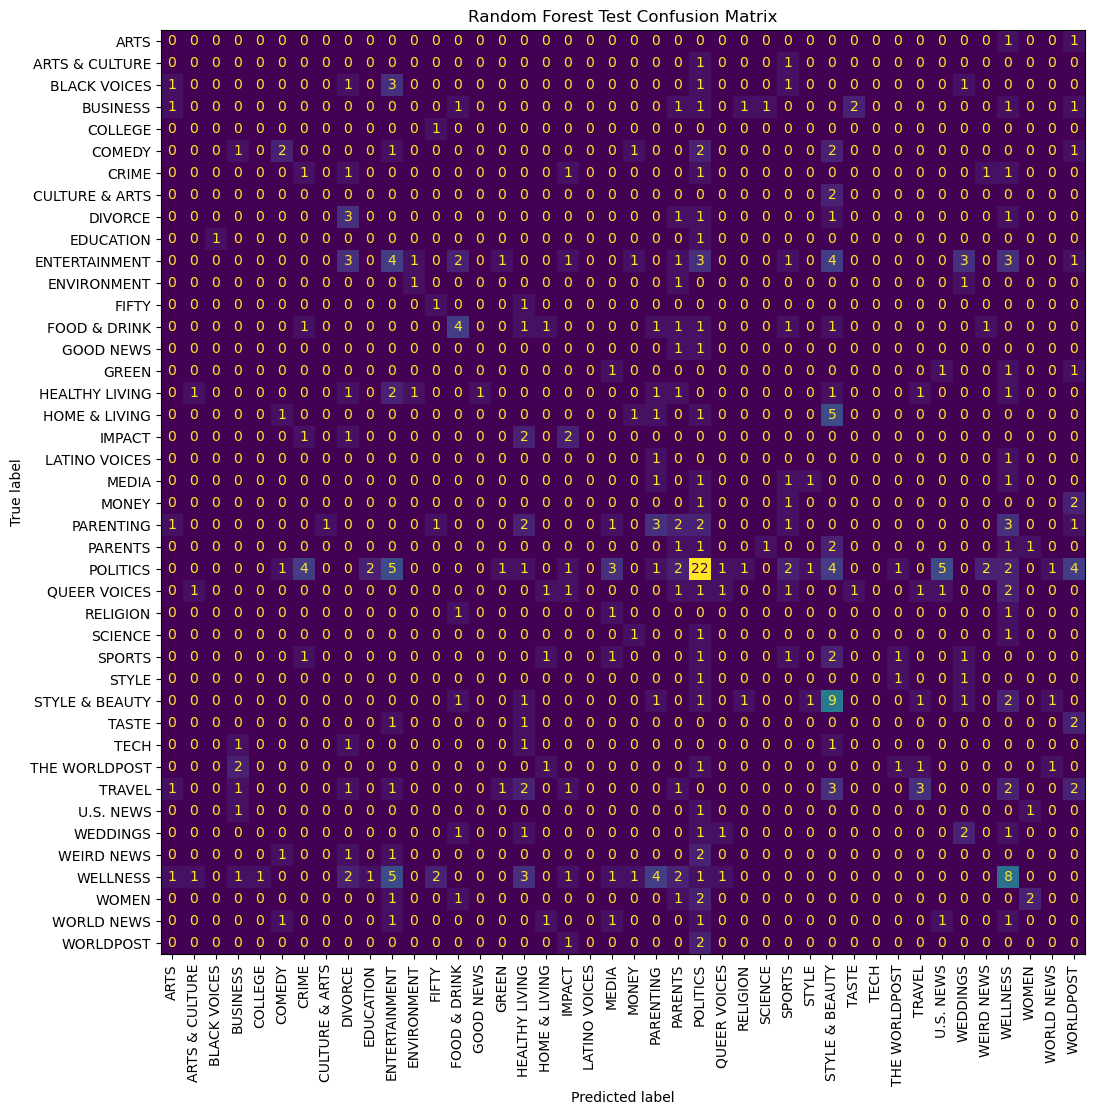

In [36]:
#test confusion matrix
ConfusionMatrixDisplay.from_predictions(test_y, test_predictions, display_labels=label_encoder.classes_, colorbar=False, xticks_rotation='vertical')
plt.title('Random Forest Test Confusion Matrix')
plt.show()

## XGBoost Classifier

In [37]:
clf = xgb.XGBClassifier(objective='multi:softmax', num_class=len(label_encoder.classes_), n_estimators=50, max_depth=4, random_state=42)
clf.fit(train_x, train_y, eval_set=[(test_x, test_y)])

[0]	validation_0-mlogloss:3.26442
[1]	validation_0-mlogloss:3.15156
[2]	validation_0-mlogloss:3.07116
[3]	validation_0-mlogloss:3.01000
[4]	validation_0-mlogloss:2.96487
[5]	validation_0-mlogloss:2.93908
[6]	validation_0-mlogloss:2.93441
[7]	validation_0-mlogloss:2.91903
[8]	validation_0-mlogloss:2.90647
[9]	validation_0-mlogloss:2.89908
[10]	validation_0-mlogloss:2.89951
[11]	validation_0-mlogloss:2.90543
[12]	validation_0-mlogloss:2.91040
[13]	validation_0-mlogloss:2.91105
[14]	validation_0-mlogloss:2.90112
[15]	validation_0-mlogloss:2.90593
[16]	validation_0-mlogloss:2.90898
[17]	validation_0-mlogloss:2.92136
[18]	validation_0-mlogloss:2.92476
[19]	validation_0-mlogloss:2.92961
[20]	validation_0-mlogloss:2.93512
[21]	validation_0-mlogloss:2.93589
[22]	validation_0-mlogloss:2.93974
[23]	validation_0-mlogloss:2.94622
[24]	validation_0-mlogloss:2.95318
[25]	validation_0-mlogloss:2.95432
[26]	validation_0-mlogloss:2.95785
[27]	validation_0-mlogloss:2.95816
[28]	validation_0-mlogloss:2.9

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None, num_class=42,
              num_parallel_tree=None, ...)

In [38]:

train_predictions = clf.predict(train_x)
test_predictions = clf.predict(test_x)

print(f"Train accuracy: {accuracy_score(train_y, train_predictions):.3f}")
print(f"Train precision: {precision_score(train_y, train_predictions, average='weighted'):.3f}")
print(f"Train recall: {recall_score(train_y, train_predictions, average='weighted'):.3f}")
print(f"Train f1: {f1_score(train_y, train_predictions, average='weighted'):.3f}")
print("\n")
print(f"Test accuracy: {accuracy_score(test_y, test_predictions):.3f}")
print(f"Test precision: {precision_score(test_y, test_predictions, average='weighted'):.3f}")
print(f"Test recall: {recall_score(test_y, test_predictions, average='weighted'):.3f}")
print(f"Test f1: {f1_score(test_y, test_predictions, average='weighted'):.3f}")


Train accuracy: 1.000
Train precision: 1.000
Train recall: 1.000
Train f1: 1.000


Test accuracy: 0.315
Test precision: 0.284
Test recall: 0.315
Test f1: 0.258


c:\Users\domin\anaconda3\envs\nlp_env\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


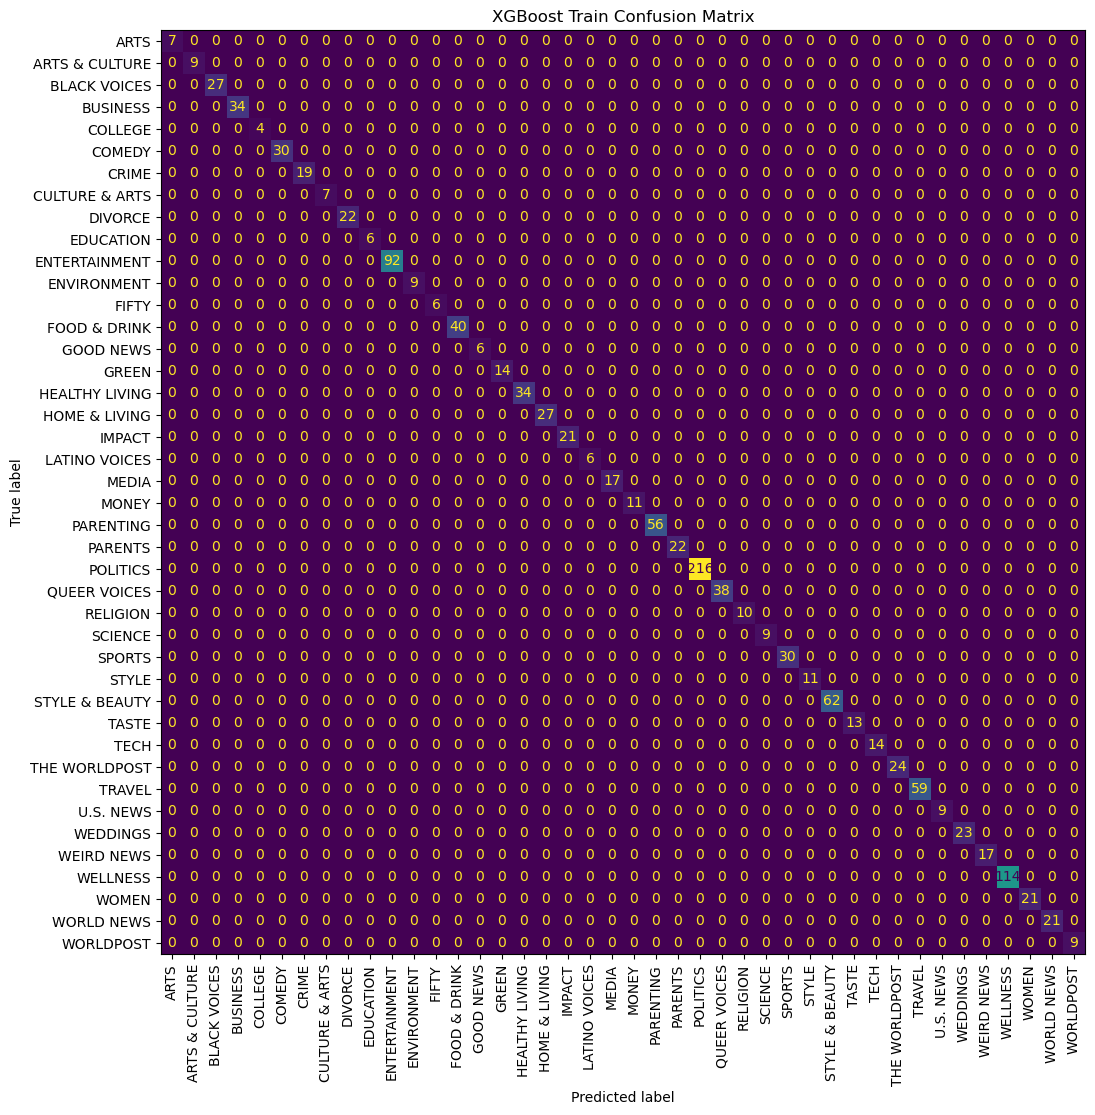

In [39]:
ConfusionMatrixDisplay.from_predictions(train_y, train_predictions, display_labels=label_encoder.classes_, colorbar=False, xticks_rotation='vertical')
plt.title('XGBoost Train Confusion Matrix')
plt.show()

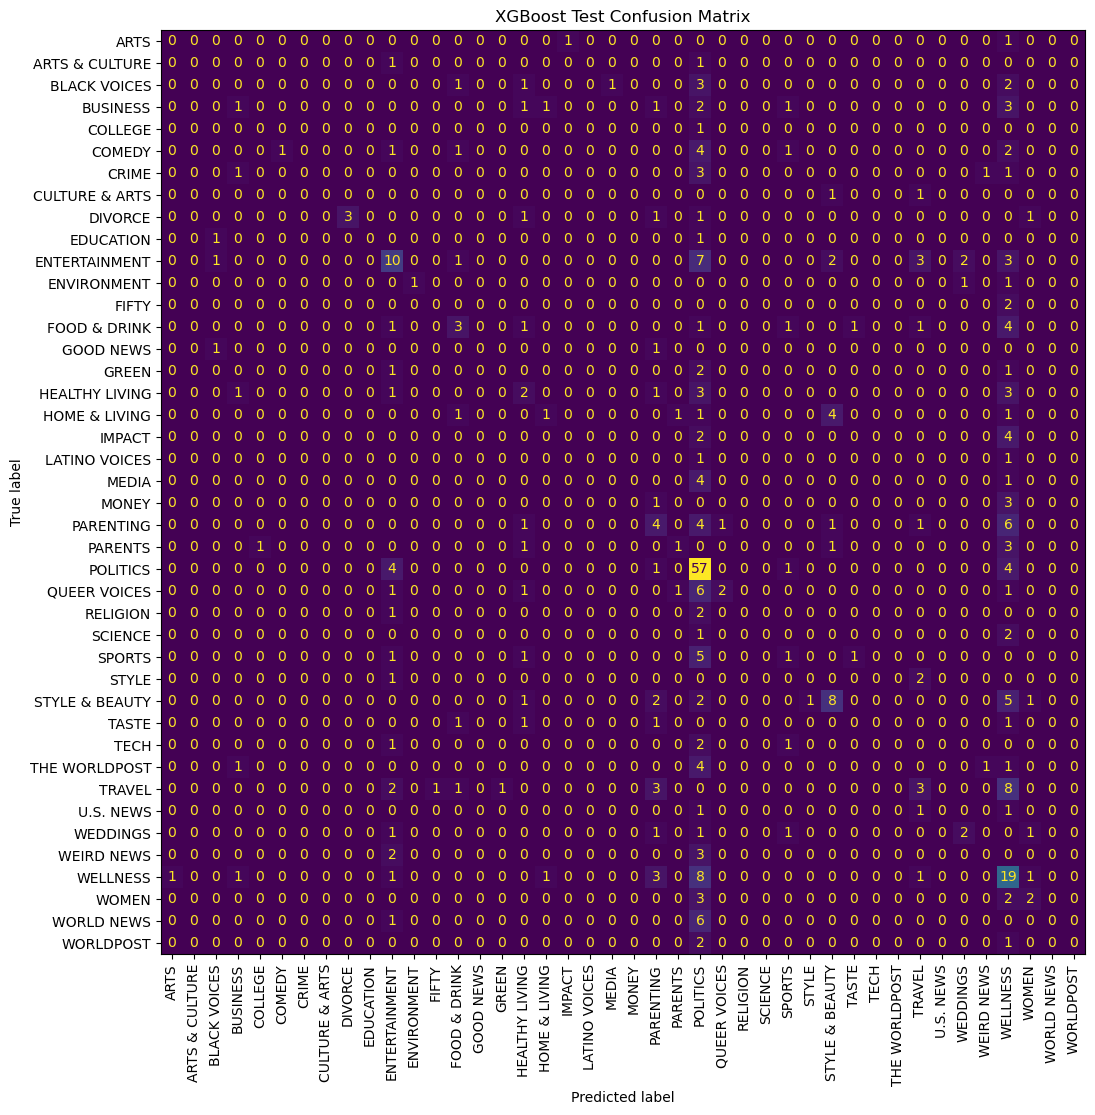

In [40]:
#test confusion matrix
ConfusionMatrixDisplay.from_predictions(test_y, test_predictions, display_labels=label_encoder.classes_, colorbar=False, xticks_rotation='vertical')
plt.title('XGBoost Test Confusion Matrix')
plt.show()

## Artificial Neural Network
copying some code from P6_ANN_CNN_Class_Exercise3_Solution.ipynb file

In [58]:
model = Sequential()
#input layer
model.add(Dense(100, input_dim=train_x.shape[1], activation='relu'))
#hidden layer?
model.add(Dense(64, activation='relu'))
#hidden layer?
model.add(Dense(64, activation='relu'))
#output layer, needs as many neurons as there are classes?
model.add(Dense(len(label_encoder.classes_), activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(train_x, train_y, validation_split = 0.2, epochs=30, batch_size=64, verbose=1)

accuracy = model.evaluate(test_x, test_y, verbose=1)
print(f"Test accuracy: {accuracy[1]:.3f}")


Epoch 1/30
62/62 [==============================] - 1s 7ms/step - loss: 3.5816 - accuracy: 0.1704 - val_loss: 3.2739 - val_accuracy: 0.1789
Epoch 2/30
62/62 [==============================] - 0s 3ms/step - loss: 3.2466 - accuracy: 0.1959 - val_loss: 3.1637 - val_accuracy: 0.2154
Epoch 3/30
62/62 [==============================] - 0s 3ms/step - loss: 3.1370 - accuracy: 0.2255 - val_loss: 3.1577 - val_accuracy: 0.1748
Epoch 4/30
62/62 [==============================] - 0s 3ms/step - loss: 3.1021 - accuracy: 0.2133 - val_loss: 3.1449 - val_accuracy: 0.2195
Epoch 5/30
62/62 [==============================] - 0s 3ms/step - loss: 3.0883 - accuracy: 0.2204 - val_loss: 3.1190 - val_accuracy: 0.2236
Epoch 6/30
62/62 [==============================] - 0s 3ms/step - loss: 3.0650 - accuracy: 0.2235 - val_loss: 3.2032 - val_accuracy: 0.2195
Epoch 7/30
62/62 [==============================] - 0s 3ms/step - loss: 3.0575 - accuracy: 0.2194 - val_loss: 3.1379 - val_accuracy: 0.2317
Epoch 8/30
62/62 [==

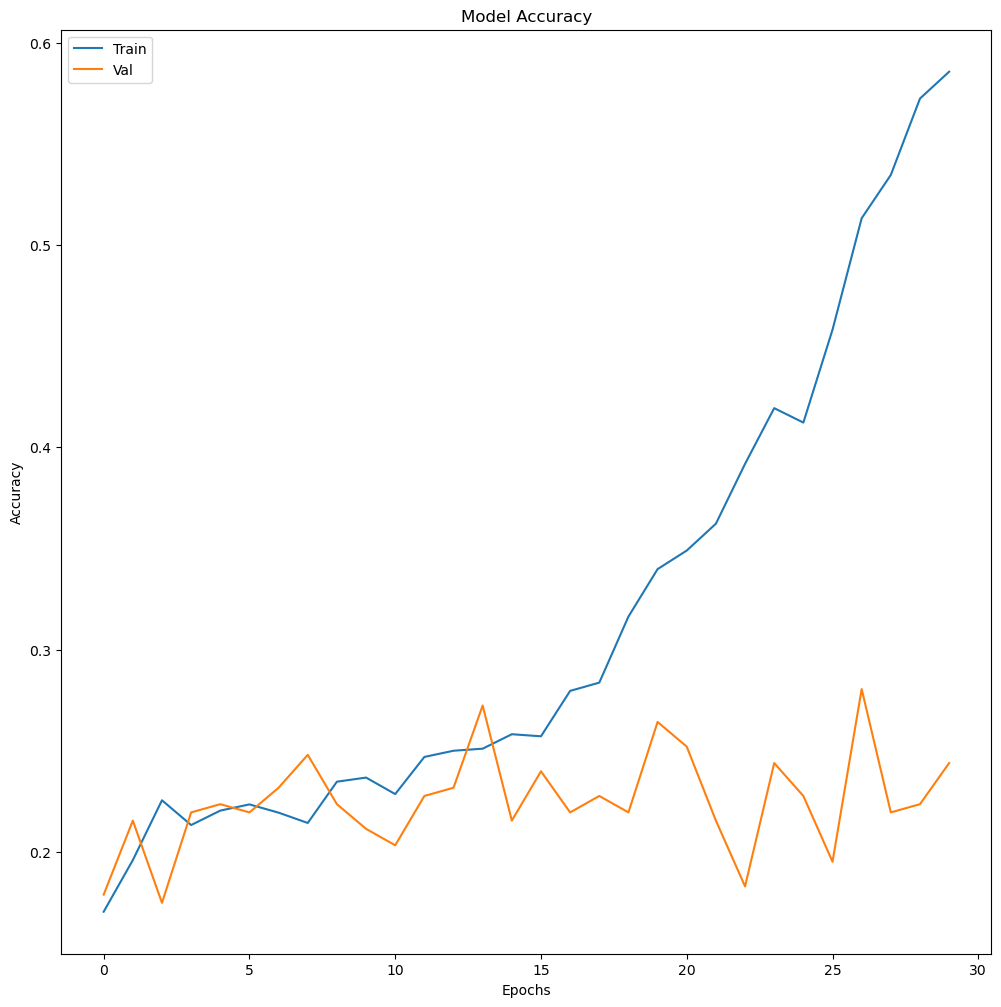

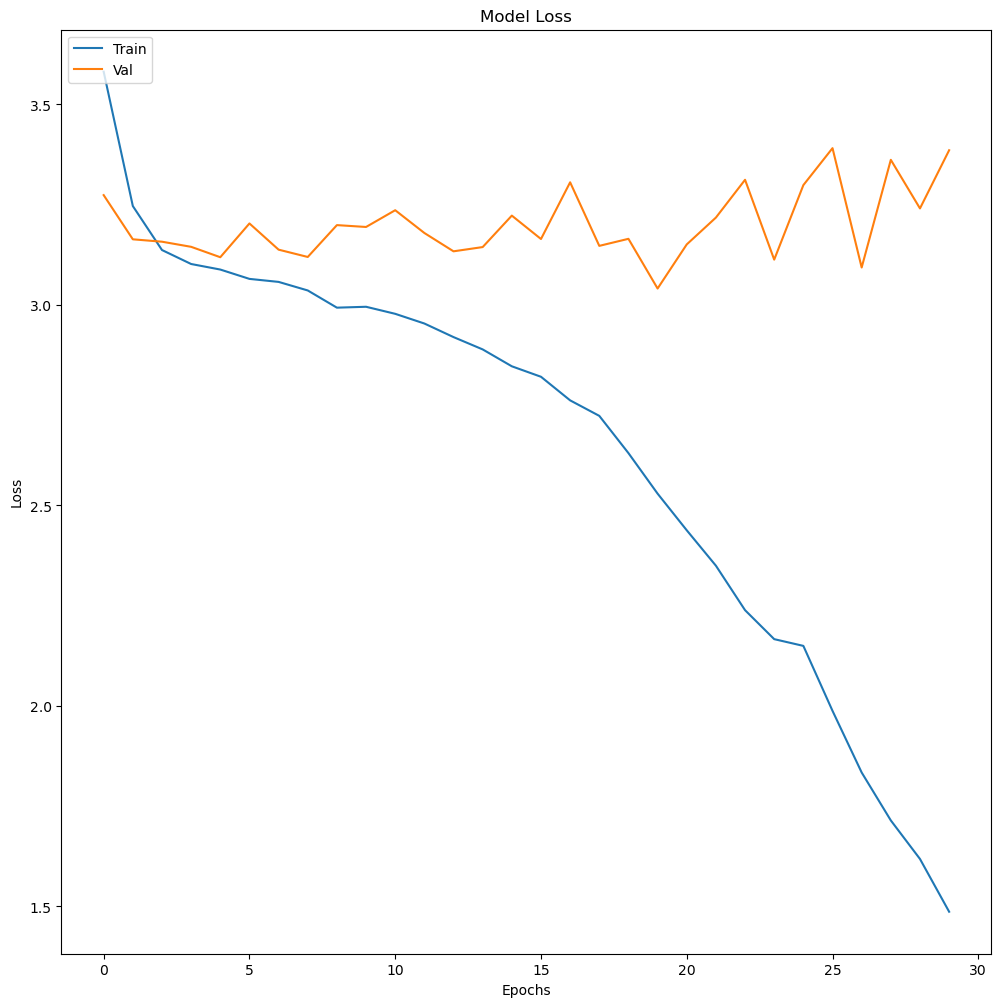

In [59]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.xlabel('Epochs')

plt.ylabel('Accuracy')

plt.legend(['Train', 'Val'], loc='upper left')

plt.show()

# plot the loss of the model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])


plt.title('Model Loss')
plt.xlabel('Epochs')

plt.ylabel('Loss')

plt.legend(['Train', 'Val'], loc='upper left')

plt.show()

12/12 [==============================] - 0s 2ms/step


<Axes: >

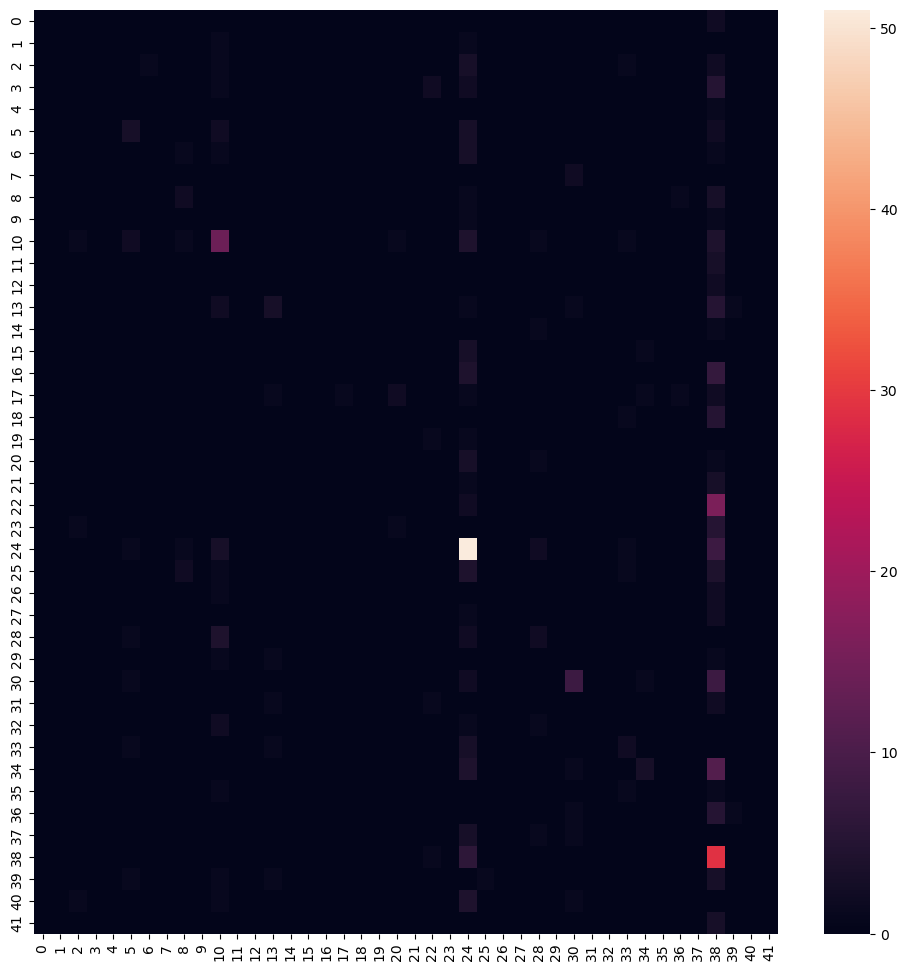

In [91]:
y_pred = model.predict(test_x)


y_pred = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(test_y, y_pred)
sns.heatmap(conf_matrix)

# Convolutional Neural Network
stealing code from P6_ANN_CNN_Exercise4_Solution

In [92]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(train_x.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

cnn_train_x = train_x.to_numpy().reshape(train_x.shape[0], train_x.shape[1], 1)
cnn_test_x = test_x.to_numpy().reshape(test_x.shape[0], test_x.shape[1], 1)

early_stopping = EarlyStopping(patience=3)
model.fit(cnn_train_x, train_y, validation_split = 0.2, epochs=30, batch_size=train_x.shape[1]//50, verbose=1, callbacks=[early_stopping])

cnn_y_pred = model.predict(cnn_test_x)

accuracy_cnn = accuracy_score(test_y, np.argmax(cnn_y_pred, axis=1))
accuracy_cnn


Epoch 1/30
62/62 [==============================] - 2s 18ms/step - loss: 3.7350 - accuracy: 0.1357 - val_loss: 3.5459 - val_accuracy: 0.1707
Epoch 2/30
62/62 [==============================] - 1s 15ms/step - loss: 3.5406 - accuracy: 0.1765 - val_loss: 3.4584 - val_accuracy: 0.1707
Epoch 3/30
62/62 [==============================] - 1s 14ms/step - loss: 3.4869 - accuracy: 0.1878 - val_loss: 3.4126 - val_accuracy: 0.1748
Epoch 4/30
62/62 [==============================] - 1s 14ms/step - loss: 3.4234 - accuracy: 0.1949 - val_loss: 3.3807 - val_accuracy: 0.1829
Epoch 5/30
62/62 [==============================] - 1s 14ms/step - loss: 3.3912 - accuracy: 0.1908 - val_loss: 3.3474 - val_accuracy: 0.2033
Epoch 6/30
62/62 [==============================] - 1s 14ms/step - loss: 3.3823 - accuracy: 0.1939 - val_loss: 3.3223 - val_accuracy: 0.1992
Epoch 7/30
62/62 [==============================] - 1s 14ms/step - loss: 3.3482 - accuracy: 0.2020 - val_loss: 3.3060 - val_accuracy: 0.2114
Epoch 8/30
6

0.21614583333333334

12/12 [==============================] - 0s 4ms/step


<Axes: >

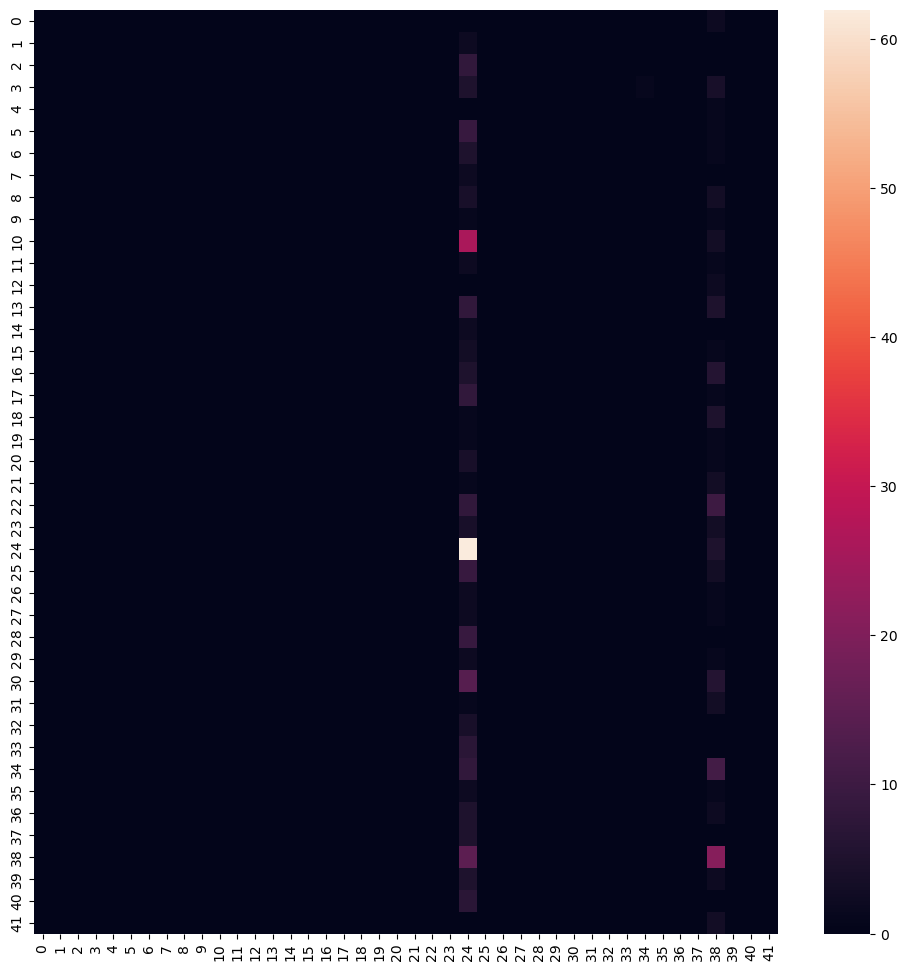

In [93]:
y_pred = model.predict(test_x)

y_pred = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(test_y, y_pred)
sns.heatmap(conf_matrix)